# Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

# Challenge Description

Company XYZ sells a software for \\$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66 percent of the users have seen the old price (\\$39), while a random sample of 33% users a higher price (\\$59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

* **Should the company sell its software for \\$39 or \\$59?**
* The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. **What are your main findings looking at the data?**
* [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? **After how many days you would have stopped the test?** Please, explain why.

# Data
## "test_results" - data about the test
* **user_id** : the Id of the user. Can be joined to user_id in user_table 
* **timestamp** : the date and time when the user hit for the first time company XYZ webpage. It is in user local time 
* **source** : marketing channel that led to the user coming to the site. It can be: 
    * ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc.
    * seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.
    * friend_referral : user coming from a referral link of another user
    * direct_traffic: user coming by directly typing the address of the site on the browser
* **device** : user device. Can be mobile or web
operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. "Other" if it is none of the above
* **test**: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old/lower price)
* **price** : the price the user sees. It should match test
* **converted** : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

## "user_table" - Information about the user

* **user_id** : the Id of the user. Can be joined to user_id in test_results table 
* **city** : the city where the user is located. Comes from the user ip address 
* **country** : in which country the city is located
* **lat** : city latitude - should match user city
* **long** : city longitude - should match user city

# Analysis

In [71]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [110]:
test=pd.read_csv('test_results.csv', parse_dates=['timestamp'])
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [111]:
user=pd.read_csv('user_table.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [113]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


## Data Processing and Cleaning

In [114]:
data = pd.merge(left=test, right=user, how='left', on='user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [115]:
len(data)

316800

In [116]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

Based on the description, the test labeled as 1 is higher price and test labeled as 0 is lower price. The test label should matched the price. However, there are some records that test label didn't match price. The first step is to remove these problematic inputs.

In [117]:
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [118]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


## EDA
### Source

In [141]:
data['revenue']=data['price']*data['converted']
source=data[['source','converted','user_id','test','revenue']].groupby(['source','test']).agg({'converted':'sum','user_id':'count','revenue':'mean'})
source.rename(columns={'user_id':'frequency','revenue':'mean_revenue'},inplace=True)
##source.reset_index()
source['converted_rate']=round(source['converted']/source['frequency'],4)*100
source=source.reset_index()
source

,source,test,converted,frequency,mean_revenue,converted_rate
0,ads-bing,0,195,14584,0.521462,1.34
1,ads-bing,1,79,8247,0.565175,0.96
2,ads-google,0,854,37845,0.880063,2.26
3,ads-google,1,422,21497,1.158208,1.96
4,ads-yahoo,0,81,4812,0.656484,1.68
5,ads-yahoo,1,31,2759,0.662921,1.12
6,ads_facebook,0,806,34074,0.922522,2.37
7,ads_facebook,1,325,19281,0.994502,1.69
8,ads_other,0,297,19256,0.601527,1.54
9,ads_other,1,131,10570,0.731220,1.24


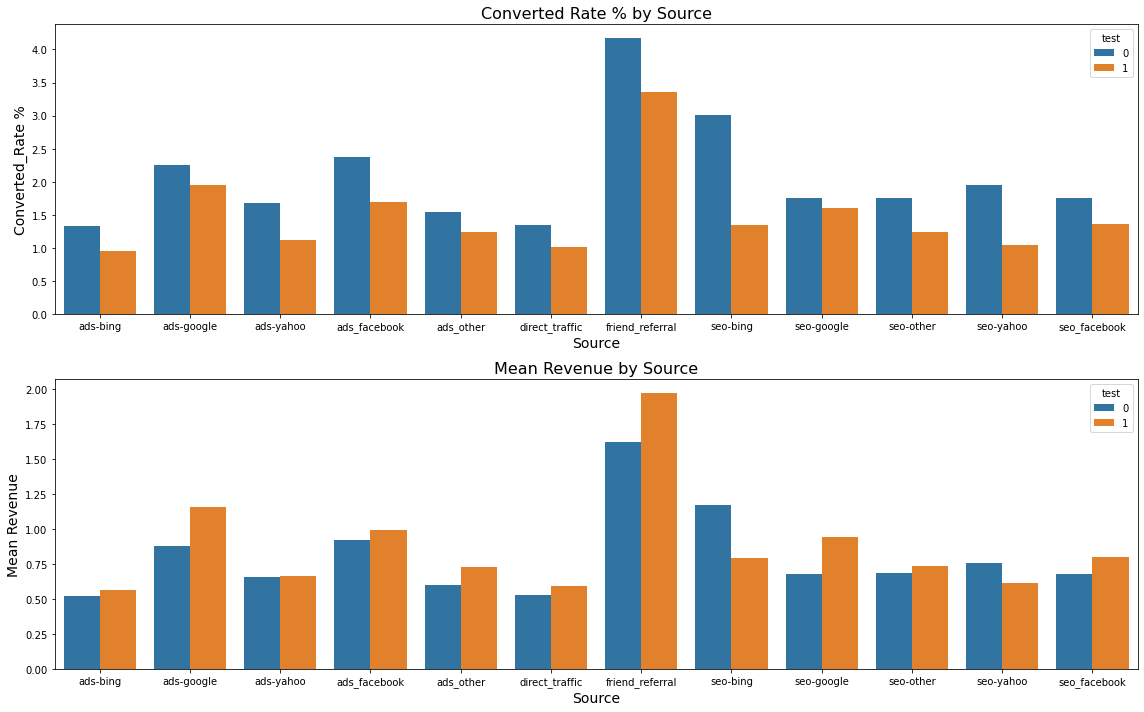

In [62]:
fig, ax=plt.subplots(nrows=2,ncols=1,figsize=(16,10))
sns.barplot(x='source',y='converted_rate',hue='test',data=source,ax=ax[0])
ax[0].set_xlabel('Source',fontsize=14)
ax[0].set_ylabel('Converted_Rate %',fontsize=14)
ax[0].set_title('Converted Rate % by Source',fontsize=16)

sns.barplot(x='source',y='mean_revenue',hue='test',data=source,ax=ax[1])
ax[1].set_xlabel('Source',fontsize=14)
ax[1].set_ylabel('Mean Revenue',fontsize=14)
ax[1].set_title('Mean Revenue by Source',fontsize=16)
plt.tight_layout()
plt.show()

### Device

In [63]:
device=data[['device','converted','user_id','test','revenue']].groupby(['device','test']).agg({'converted':'sum','user_id':'count','revenue':'mean'})
device.rename(columns={'user_id':'frequency','revenue':'mean_revenue'},inplace=True)
##device.reset_index()
device['converted_rate']=round(device['converted']/device['frequency'],4)*100
device=device.reset_index()
device.head(6)

,device,test,converted,frequency,mean_revenue,converted_rate
0,mobile,0,2392,120369,0.775017,1.99
1,mobile,1,1064,65898,0.952624,1.61
2,web,0,1638,82148,0.777645,1.99
3,web,1,708,48020,0.869888,1.47


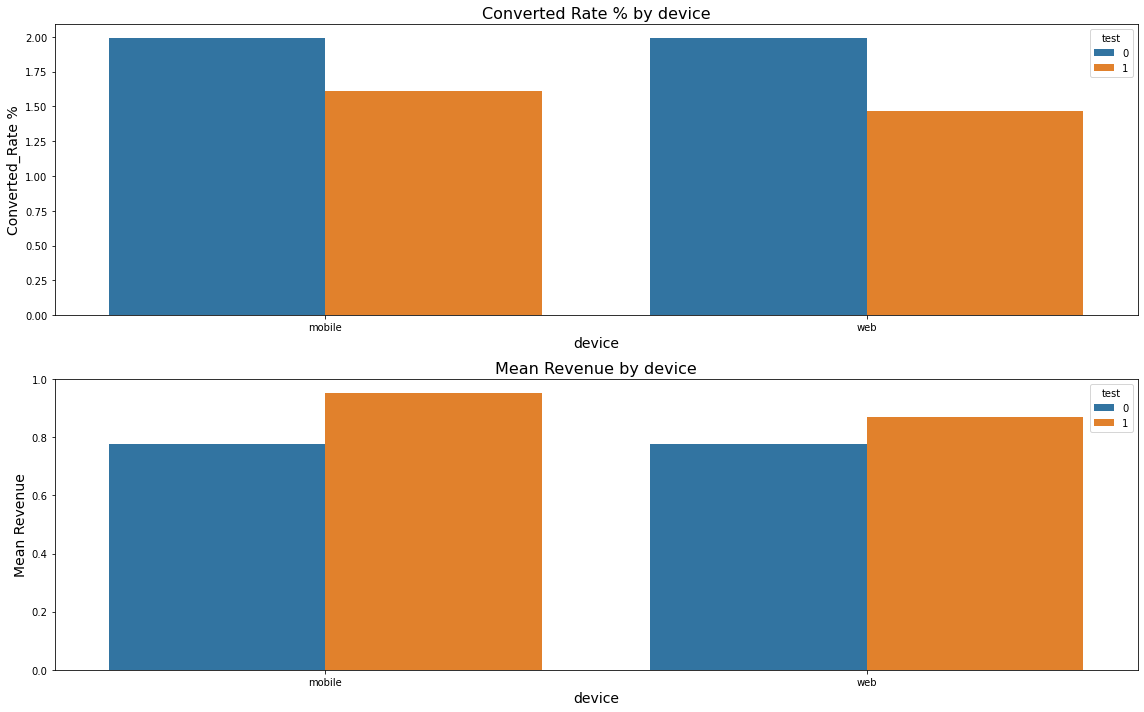

In [64]:
fig, ax=plt.subplots(nrows=2,ncols=1,figsize=(16,10))
sns.barplot(x='device',y='converted_rate',hue='test',data=device,ax=ax[0])
ax[0].set_xlabel('device',fontsize=14)
ax[0].set_ylabel('Converted_Rate %',fontsize=14)
ax[0].set_title('Converted Rate % by Device',fontsize=16)

sns.barplot(x='device',y='mean_revenue',hue='test',data=device,ax=ax[1])
ax[1].set_xlabel('device',fontsize=14)
ax[1].set_ylabel('Mean Revenue',fontsize=14)
ax[1].set_title('Mean Revenue by Device',fontsize=16)
plt.tight_layout()
plt.show()

### Operative System

In [76]:
operative_system=data[['operative_system','converted','user_id','test','revenue']].groupby(['operative_system','test']).agg({'converted':'sum','user_id':'count','revenue':'mean'})
operative_system.rename(columns={'user_id':'frequency','revenue':'mean_revenue'},inplace=True)
##operative_system.reset_index()
operative_system['converted_rate']=round(operative_system['converted']/operative_system['frequency'],4)*100
operative_system=operative_system.reset_index()
operative_system

,operative_system,test,converted,frequency,mean_revenue,converted_rate
0,android,0,787,48177,0.637088,1.63
1,android,1,330,26693,0.729405,1.24
2,iOS,0,1458,61793,0.920201,2.36
3,iOS,1,671,33560,1.179648,2.00
4,linux,0,34,2204,0.601633,1.54
5,linux,1,0,1926,0.000000,0.00
6,mac,0,416,16345,0.992597,2.55
7,mac,1,185,8710,1.253157,2.12
8,other,0,147,10481,0.546990,1.40
9,other,1,63,5696,0.652563,1.11


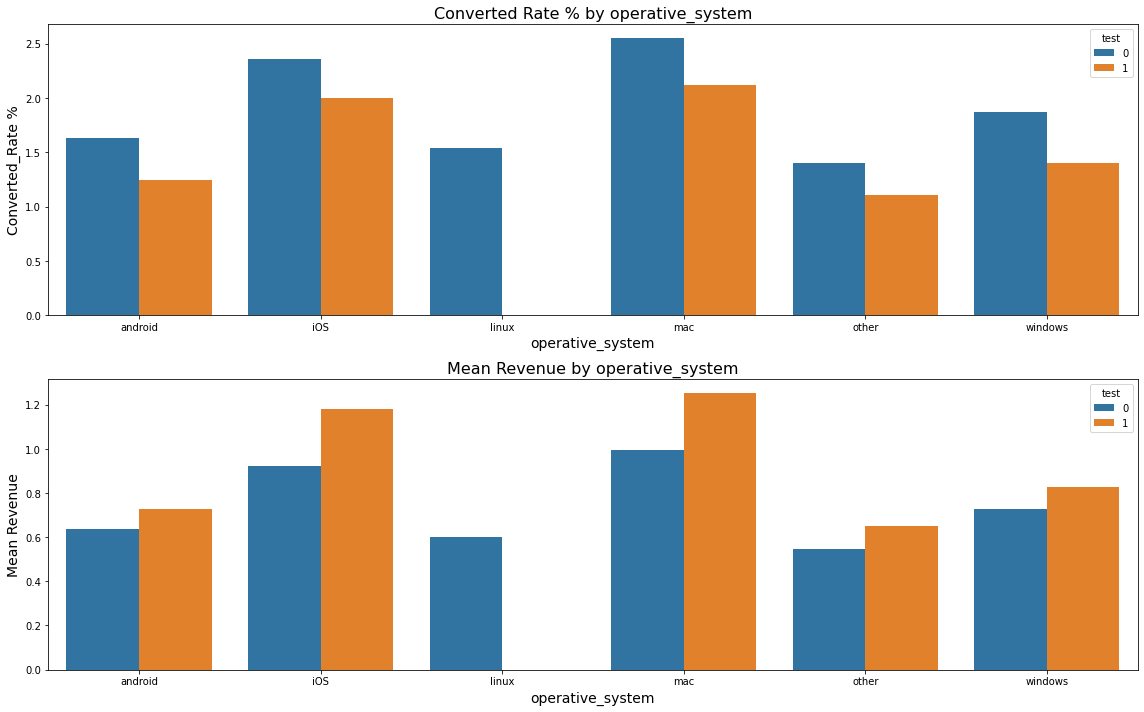

In [66]:
fig, ax=plt.subplots(nrows=2,ncols=1,figsize=(16,10))
sns.barplot(x='operative_system',y='converted_rate',hue='test',data=operative_system,ax=ax[0])
ax[0].set_xlabel('operative_system',fontsize=14)
ax[0].set_ylabel('Converted_Rate %',fontsize=14)
ax[0].set_title('Converted Rate % by operative_system',fontsize=16)

sns.barplot(x='operative_system',y='mean_revenue',hue='test',data=operative_system,ax=ax[1])
ax[1].set_xlabel('operative_system',fontsize=14)
ax[1].set_ylabel('Mean Revenue',fontsize=14)
ax[1].set_title('Mean Revenue by operative_system',fontsize=16)
plt.tight_layout()
plt.show()

## Analysis

In [67]:
data[['test', 'converted']].groupby('test').mean()


,converted
test,
0,0.019900
1,0.015555


In [69]:
data[['test', 'revenue']].groupby('test').mean()


,revenue
test,
0,0.776083
1,0.917748


Clearly, for those with lower price \\$39, they have a higher conversion rate 1.99\%. For those with higher price \$59, the conversion rate is 1.56%. However, considering the price, the average revenue for higher price (0.918) is actually larger than the lower price (0.776).

### T-test

Now, let's conduct hypothesis testing.

Null hypothesis $H_0$: experimental group's average revenue is equal to or less than control group's average revenue 

Alternative hypothesis $H_1$: experimental group's average revenue is higher than control group's average revenue

In [73]:
ctr_val = data[data['test'] == 0]['revenue'].values
exp_val = data[data['test'] == 1]['revenue'].values
print(ttest_ind(exp_val, ctr_val, axis=0, equal_var=False))

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)


The t-test above is actually two-tailed test if we want to get a one tail t-test, we should divided the p-value by 2. Based on p-value we can easily tell that experimental group's average revenue is higher than control group's average revenue.

### Behavior Analysis

From EDA, we can easily conclude that price dramatically influence the conversion rate. But besides that, there are still other factors that can influence the conversion rate.

* Source
    * Friend-referral users have much higher conversion rate  
    * After increasing price, the converted rate of users from bing source drop dramatically
* Device
    * The influence of device is not significant when price is \$39
    * After increasing the price, the mobile has a higher conversion rate
* Operative System
    * Mac and ios users have much higher conversion rate
    * Increasing the price will lose Linux users. None of linux users were converted.

In [127]:
data['day']=data['timestamp'].apply(lambda x: x[:10])

### Bonus

Currently, the price-test lasts 91 days from 2015-03-02 to 2015-05-31 which is 13 weeks. Although the t-test result shows significant, for a A/B test, the test cycle is too long. I'd recommend 4 weeks as A/B test cycle.



In [131]:
len(data['day'].unique())


91

In [142]:
data[data['day']<'2015-04-02'][['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019679
1,0.016115


Running a test for more than 3 months is risky because many of the conditions will have changed over such a long period. 